In [1]:
import numpy as np
import scipy.stats as sc
from matplotlib import colormaps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from time import time

In [2]:
# ground truth data
ground_truths = np.load('mt_trajectories.npy')
ground_truths

array([[[ -8.07218076,  -4.49125581,  -0.91033086,   2.67059409,
           6.25151904,   9.83244399,  13.41336894,  16.99429389,
          20.57521884,  24.15614379],
        [ -0.8844742 ,  -2.77044353,  -4.65641285,  -6.54238217,
          -8.4283515 , -10.31432082, -12.20029014, -14.08625947,
         -15.97222879, -17.85819811],
        [ -3.88086752,  -2.92152956,  -1.96219159,  -1.00285363,
          -0.04351567,   0.91582229,   1.87516025,   2.83449821,
           3.79383618,   4.75317414]],

       [[ -6.46454434,  -3.36883308,  -0.27312181,   2.82258945,
           5.91830072,   9.01401198,  12.10972325,  15.20543452,
          18.30114578,  21.39685705],
        [  5.1703906 ,   6.05898913,   6.94758765,   7.83618618,
           8.72478471,   9.61338324,  10.50198177,  11.3905803 ,
          12.27917883,  13.16777736],
        [ -1.3581392 ,  -0.35850924,   0.64112072,   1.64075068,
           2.64038064,   3.6400106 ,   4.63964056,   5.63927052,
           6.63890048,   7.6

## Background

### Motion model

In [3]:
# # utility functions
# this is the version for [x, dx, y, dy]
# def create_state_matrix(dt:float= 1.0, dim:int = 2):
#     mat = []
#     for i in range(dim):
#         row = []
#         for j in range(dim):
#             if i == j:
#                 row.append(np.array([[1, dt], [0, 1]]))
#             else:
#                 row.append(np.zeros((2, 2)))
#         mat.append(row)
#     return np.block(mat)

def create_state_matrix(dt:float = 1.0, dim:int = 2)->np.ndarray:
    """Creates a state transition matrix for an n-dimensional constant velocity model.

    The matrix is composed of four (dim x dim) blocks:

        [ I   I*dt ]
        [ 0     I  ]

    where:
        - I is the identity matrix
        - 0 is the zero matrix
        - dt is the timestep length

    Args:
        dt (float, optional): Length of a single timestep. Defaults to 1.0.
        dim (int, optional): Number of spatial dimensions. Set to 2 for 2D (x, y) motion, 3 for 3D (x, y, z) motion, etc. Defaults to 2.

    Returns:
        np.ndarray: The state transition matrix.
    """
    return np.vstack((
        np.hstack((np.identity(dim), np.identity(dim) * dt)),
        np.hstack((np.zeros((dim, dim)), np.identity(dim)))
    ))


def create_measurement_matrix(dim:int = 2)->np.ndarray:
    """Creates a measurement matrix for an n-dimensional constant velocity model.

    The matrix H maps the full state to position measurements only:

        [ I  0 ]

    where:
        - I is the identity matrix (measures position)
        - 0 is the zero matrix (ignores velocity)

    Args:
        dim (int, optional): Number of spatial dimensions. Set to 2 for 2D (x, y) motion, 3 for 3D (x, y, z) motion, etc. Defaults to 2.

    Returns:
        np.ndarray: The measurement matrix.
    """
    return np.hstack((np.identity(dim), np.zeros((dim, dim))))

The motion model describes how objects of a system move. Define the motion model as $$x_{k+1} = F \times x_{k} + w_{k}$$ where
\begin{gather*}
    \text{$x_{k+1}$: next state} \\
    \text{$F$: state transition matrix} \\
    \text{$x_{k}$: current state} \\
    \text{$w_{k}$: process noise.} \\
\end{gather*}

Assume motion is constant velocity in 2 dimensions, where state is represented by $[x, y, v_{x}, v_{y}]$ (i.e., x-pos, y-pos, x-vel, y-vel). Then, $F$ is defined by
$$ F = \begin{bmatrix}
    1 & 0 & dt & 0 \\
    0 & 1 & 0 & dt \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
\end{bmatrix}.$$

In [4]:
# dimensions
dim = 2
# timestep (1s)
dt = 1.0
# state transition matrix
F = create_state_matrix(dt, dim)
F

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Assume $w_{k}$ has 0 mean and 0.25 variance. Sampled from a multivariate Gaussian, its covariance $Q$ is defined by
$$ Q = \begin{bmatrix}
    0.25 & 0 & 0 & 0 \\
    0 & 0.25 & 0 & 0 \\
    0 & 0 & 0.25 & 0 \\
    0 & 0 & 0 & 0.25 \\
\end{bmatrix}.$$

In [5]:
# process noise covariance
Q = np.identity(F.shape[0]) * 0.25
Q

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [6]:
def simulate_motion_basic(num_steps:int=10, init_truths:int=3)->dict[int, list[np.ndarray]]:
    """Simulates simple motion of multiple objects in an n-dimensional space.

    Args:
        num_steps (int, optional): Number of timesteps to simulate. Defaults to 10.
        init_truths (int, optional): Number of initial objects. Defaults to 3.

    Returns:  
        dict[int, list[np.ndarray]]: Dictionary containing the states of each object at each timestep. Each key is the object index (0, 1, 2, ...). Each value is a list of state vectors with shape (4,) representing (x, y, dx, dy). 
    """
    all_states = {}
    # initial truths
    for i in range(init_truths):
        state = np.array([
            # initial position (x, y) ~ U(-30, 30) x U(-30, 30)
            *np.random.uniform(-30, 30, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            *np.random.uniform(-2, 2, 2),
        ])

        all_states[i] = [state.copy()]

    for step in range(1, num_steps + 1):
        
        # propagate state for each object
        for i in all_states.keys():
            # get previous state
            state = all_states[i][-1]

            # propagate state with noise
            new_state = F @ state + np.random.multivariate_normal(np.zeros(Q[0].size), Q)
            
            all_states[i].append(new_state.copy())

    return all_states


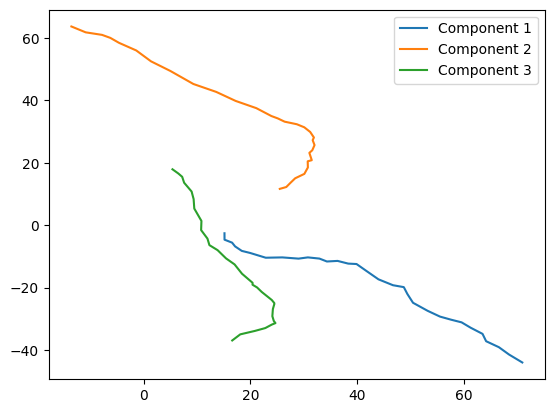

In [7]:
# generate ground truths (i.e., true motion)
# assume 3 components
%matplotlib inline
num_components = 3
ground_truths = simulate_motion_basic(num_steps=30, init_truths=num_components)
for i, state in ground_truths.items():
    pos = np.array([s[:2] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    plt.legend()
plt.show()

Now, assume objects have a specific birth and death probability. Birth refers to the spontaneous introduction of an object into a scene, whereas death refers to the spontaneous removal of an object from a scene.

In [8]:
def simulate_motion(F:np.ndarray, Q:np.ndarray, num_steps:int = 10, init_truths:int = 3, birth_prob:float = 0.2, death_prob:float = 0.05)->dict[int, list[np.ndarray]]:
    """Simulates the motion of multiple objects in an n-dimensional space with birth and death probabilities. A generalized form of the previous method to include birth and death probabilities.   

    Args:
        F (np.ndarray): State transition matrix. Must match the dimensions of the state vector.
        Q (np.ndarray): Process noise covariance matrix. Must match the dimensions of the state vector.
        num_steps (int, optional): Number of timesteps to simulate. Defaults to 10.
        init_truths (int, optional): Number of initial objects. Defaults to 3.
        birth_prob (float, optional): Probability that a new object is born. Defaults to 0.2.
        death_prob (float, optional): Probability that an existing object dies. Defaults to 0.05.

    Returns:  
        dict[int, list[np.ndarray]]: Dictionary containing the states of each object at each timestep. Each key is the object index (0, 1, 2, ...). Each value is a list of state vectors with shape (4,) representing (x, y, dx, dy). 
    """
    
    all_states = {}
    # initial truths
    for i in range(init_truths):
        state = np.array([
            # initial position (x, y) ~ U(-30, 30) x U(-30, 30)
            *np.random.uniform(-30, 30, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            *np.random.uniform(-2, 2, 2),
        ])

        # initial state at t=0
        all_states[i] = [state.copy()]

    # next id for new objects that are born
    next_id = init_truths

    for step in range(1, num_steps + 1):
        
        for i in all_states.keys():
            # get i's previous (t-1) state
            state = all_states[i][-1]

            # if dead, stay dead
            if state is None:
                # None is used to indicate that the object is dead at this timestep
                all_states[i].append(None)
                continue

            # death
            if np.random.rand() <= death_prob:
                # None is used to indicate that the object is dead at this timestep
                all_states[i].append(None)
                continue

            # propagate state (with noise) for each object
            new_state = F @ state + np.random.multivariate_normal(np.zeros(Q[0].size), Q)

            all_states[i].append(new_state.copy())

        # birth
        if np.random.rand() <= birth_prob:
            state = np.array([
                *np.random.uniform(-30, 30, 2),
                *np.random.uniform(-2, 2, 2),
            ])
            # since we are adding a new object, we need to set its state to None for all previous timesteps
            all_states[next_id] = [None] * step + [state.copy()]

            # increment id for the next new object
            next_id += 1

    return all_states

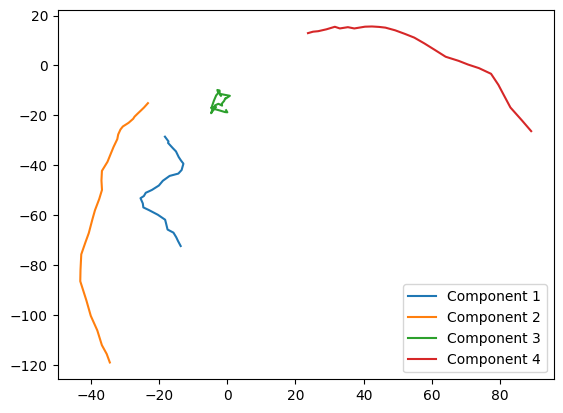

In [9]:
birth_death_truths = simulate_motion(F, Q, num_steps=30, birth_prob=0.05, death_prob=0.005)
for i, state in birth_death_truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
plt.legend()

### Measurement model

The measurement model describes what the sensor sees. Define the measurement model as $$ z_{k} = Hx_{k} + v_{k}$$ where
\begin{gather*}
    \text{$z_{k}$: observed measurement} \\
    \text{$H$: measurement matrix} \\
    \text{$v_{k}$: measurement noise.} \\
\end{gather*}

Assume a sensor only measures position. Then, $H$ is defined by
$$ H = \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
\end{bmatrix}.$$


In [10]:
# measurement matrix
H = create_measurement_matrix(dim)
H

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]])

Assume $v_{k}$ has 0 mean and 0.75 variance. Its covariance R is defined by
$$ R = \begin{bmatrix}
    0.75 & 0 \\
    0 & 0.75 \\
\end{bmatrix}.$$

In [11]:
# measurement noise covariance
R = np.identity(H.shape[0]) * 0.75
R

array([[0.75, 0.  ],
       [0.  , 0.75]])

Assume the sensors have a certain detection rate. Sensors frequently detect objects that are not targets of interest. These objects are referred to as clutter, which have to be filtered out from predictions.

In [12]:
def simulate_measurement(ground_truths:dict[int, list[np.ndarray]], H:np.ndarray, R:np.ndarray, num_steps:int=10, det_prob:float=0.9, clutter_rate:float=3.0)->dict[int, list[tuple[int, np.ndarray]]]:
    """Simulates the measurement process for multiple objects in an n-dimensional space.

    Args:
        ground_truths (dict[int, list[np.ndarray]]): 
            Dictionary containing the states of each object at each timestep. Each key is the object index (0, 1, 2, ...). Each value is a list of state vectors with shape (4,) representing (x, y, dx, dy).
            
        H (np.ndarray): 
            Measurement matrix. Must match the dimensions of the state vector.

        R (np.ndarray): 
            Measurement noise covariance matrix. Must match the dimensions of the measurement vector. 

        num_steps (int, optional): 
            Number of timesteps to simulate. Defaults to 10.

        det_prob (float, optional): 
            Probability of correctly detecting an object at each timestep. Defaults to 0.9.

        clutter_rate (float, optional): 
            Rate at which clutter (false measurements) appears in the measurement process, modeled by a Poisson distribution. Defaults to 3.0.

    Returns:
        dict[int, list[tuple[int, np.ndarray]]]: 
            Dictionary containing the measurements at each timestep, where:
                - Each key is the timestep index (0, 1, 2, ...). 
                - Each value is a list of tuples, where each tuple contains
                    - the object index (or None for clutter) 
                    - the corresponding measurement vector.
    """
    
    # all measurements
    all_measurements = {}

    for step in range(num_steps):
        measurements = []

        # real measurement
        for i, states in ground_truths.items():
            # if step exceeds the number of true states, continue
            if step >= len(states):
                continue

            # get the state at the current timestep
            state = states[step]

            # if an item is dead at the current timestep, continue
            if state is None:
                continue
            
            # detect an object with detection probability
            # if the object is detected, add the measurement
            if np.random.rand() <= det_prob:
                measurement = H @ state + np.random.multivariate_normal(np.zeros(R[0].size), R)
                measurements.append((i, measurement.copy()))

        # clutter
        for _ in range(np.random.poisson(clutter_rate)):
            # clutter (x, y) ~ U(-100, 100) x U(-100, 100)
            clutter = np.array([
                np.random.uniform(-100, 100), 
                np.random.uniform(-100, 100)
            ])
            measurements.append((None, clutter.copy()))
        
        # the measurements for this timestep consist of the real measurements (obj_id, pos) and clutter (None, pos)
        all_measurements[step] = measurements

    return all_measurements


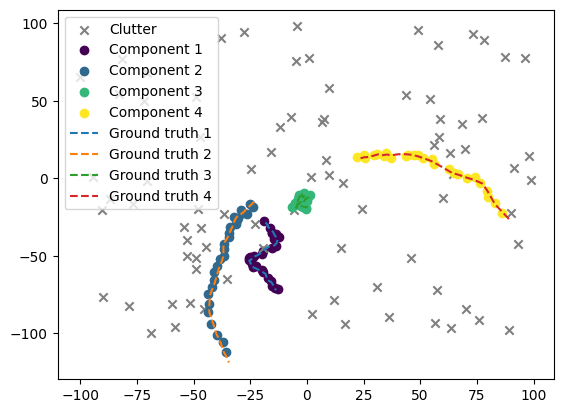

In [14]:
# generate measurements
all_measurements = simulate_measurement(birth_death_truths, H=H, R=R, num_steps=30)

component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})

# matplotlib.colormaps
cmap = colormaps['viridis']
colors = [cmap(i / max(len(component_ids) - 1, 1)) for i in range(len(component_ids))]
color_map = {comp: colors[idx] for idx, comp in enumerate(sorted(component_ids))}
# color_map = {comp: colors(idx) for idx, comp in enumerate(sorted(component_ids))}


for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='gray', marker='x', label='Clutter')
        else:
            color = color_map[i]
            plt.scatter(measurement[0], measurement[1], color=color, marker='o', label=f'Component {i + 1}')
    
for i, state in birth_death_truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    # print(pos)
    plt.plot(*pos[:,:2].T, label=f'Ground truth {i + 1}', linestyle='dashed')

# ignore duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

In [17]:
# true states
birth_death_truths

{0: [array([-18.24672674, -28.53017666,   1.11446148,  -1.9409977 ]),
  array([-17.20020937, -30.44412102,   0.36269268,  -1.10071675]),
  array([-17.32839568, -31.03577885,   1.3579903 ,  -1.64011327]),
  array([-15.91356003, -33.15022918,   0.66893778,  -1.66643111]),
  array([-15.01392508, -34.42168575,   0.58762664,  -2.41734135]),
  array([-14.20480876, -36.70364874,   0.50788206,  -1.61129307]),
  array([-13.56202898, -38.0363364 ,   0.1929231 ,  -1.87892896]),
  array([-12.82929506, -39.33715354,  -0.53461686,  -2.15047895]),
  array([-13.35560235, -41.87979227,  -1.35456365,  -1.52100511]),
  array([-14.32095884, -43.31521474,  -2.08202495,  -0.75288747]),
  array([-16.87169214, -44.24524112,  -1.67647867,  -1.09659909]),
  array([-18.8631173 , -46.19393261,  -1.31971309,  -1.29662266]),
  array([-20.02386643, -48.09150773,  -1.06672172,  -1.98903552]),
  array([-22.06147219, -49.86080698,  -0.84012235,  -1.10898504]),
  array([-23.09062565, -50.51910233,  -1.05315301,  -1.4421

In [18]:
# measurements
all_measurements

{0: [(0, array([-18.77870237, -27.83671237])),
  (2, array([ -0.24293157, -19.18665745])),
  (None, array([-94.26624659,   0.72215664]))],
 1: [(0, array([-16.48278542, -32.09110007])),
  (1, array([-25.23154467, -16.44898768])),
  (2, array([ -0.32095311, -19.63548129])),
  (None, array([ 46.04455377, -51.54358858])),
  (None, array([-86.89785765, -13.10000552]))],
 2: [(1, array([-23.69142375, -18.64145581])),
  (2, array([ -1.69548732, -18.79735952])),
  (None, array([69.64453588, 18.79984933]))],
 3: [(0, array([-15.16517033, -35.09959483])),
  (2, array([ -2.71174974, -18.14471239])),
  (None, array([ 9.56688051, 58.2882796 ])),
  (None, array([77.12430668, 39.10643762])),
  (None, array([ 57.43705921, -71.92289502]))],
 4: [(0, array([-15.55783908, -35.07211806])),
  (1, array([-28.85476478, -20.45705653])),
  (2, array([ -3.25498858, -17.28610656])),
  (3, array([22.24391609, 13.4518564 ])),
  (None, array([-27.79719794,  94.16344775])),
  (None, array([ 7.50123442, 38.35575182]

## PHD Filter

The PHD filter propagates the first-order stastical moment (mean) of the posterior multiple-target state. 

Suppose, for a multi-target scenario, that the target states at time $k - 1$ are $x_{k-1,1},...,x_{k-1,M(k-1)} \in \mathcal{X}$. For a random finite set (RFS) $X$ on $\mathcal{X}$ with probality distribution $P$, its mean is a nonnegative function $v$ on $\mathcal{X}$ (the intensity) such that
$$
\int |X \cap S| P(dX) = \int_S v(x)dx.
$$

In other words, the integral of $v$ over $S$ is the expected number of elements of $X$ in $S$.

## GM-PHD Filter

The GM-PHD filter approximates the PHD function using Gaussian mixtures. Each target is assumed to follow a linear Gaussian model. The predicted PHD (intensity) at time $k$ is then defined as $$v_{k|k-1}(x) = \sum_{i=1}^{J_{k|k-1}}{w^{i}_{k|k-1}\mathcal{N}(x, m^{i}_{k|k-1},P^{i}_{k|k-1})},$$ where 
\begin{gather*}
    \text{$J_{k|k-1}$: number of components} \\
    \text{$w^{i}_{k|k-1}$: weight of component $i$} \\
    \text{$m^{i}_{k|k-1}$: mean (state vector) of component $i$} \\
    \text{$P^{i}_{k|k-1}$: covariance of component $i$.}\\
\end{gather*}

Assume the targets are linear Gaussian. The birth and spawn RFSs of each component are Gaussian mixtures.

In [44]:
# number of components
num_components = 3

# assume each component has the same weight
component_weight = 0.1

# the variance of pos and vel
pos_var = 100
vel_var = 25

# each component assumed to start at a random (x, y) ~ U([-100, 100] x [-100, 100])
start_bounds = (-100, 100)

w = [component_weight] * num_components
m = []
for _ in range(3):
    m.append([np.random.uniform(start_bounds[0], start_bounds[1]), 0, np.random.uniform(start_bounds[0], start_bounds[1]), 0])
m = np.array(m)
P = np.diag([pos_var, pos_var, vel_var, vel_var])

print("weights",w)
print()
print("positions",m)
print()
print("covariance",P)

"""
w = weights
m = measurements 
P = covariance 
num_components = number of components
"""

weights [0.1, 0.1, 0.1]
positions [[ 56.2469882    0.         -10.90609966   0.        ]
 [ 22.30904202   0.          -4.10131286   0.        ]
 [-56.90740288   0.         -89.16461034   0.        ]]
covariance [[100   0   0   0]
 [  0  25   0   0]
 [  0   0 100   0]
 [  0   0   0  25]]


'\nw = weights\nm = measurements \nP = covariance \nnum_components = number of components\n'

In [41]:
np.save("data_in_progress/weights.npy",w)

In [39]:
from gmphd import mtt_phd

In [29]:
print(m[2])

[-44.35028365   0.          -7.41992411   0.        ]


In [25]:
print(w[0])

0.1


In [ ]:
print()